In [ ]:
!pip install evaluate
!pip install -U datasets

In [2]:
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import numpy as np

from datasets import Dataset, load_dataset
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.model_selection import train_test_split
import evaluate
import uuid

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

from datasets import load_dataset, Dataset

import warnings
warnings.filterwarnings('ignore')

### Hugging Face Hub Login
- For logging model while training

In [3]:
from huggingface_hub import login, create_repo, upload_folder

login()

### Dataset loading

In [6]:
from datasets import load_dataset

ds = load_dataset("nnudee/Thai-Thangkarn-sentence", split = 'train')
ds

Dataset({
    features: ['label', 'category', 'output', 'reasoning', 'model'],
    num_rows: 42204
})

In [7]:
# Example data from datasets
ds[0]

{'label': 'พิธีการ',
 'category': 'academic advice',
 'output': 'ข้าพระพุทธเจ้าเกล้ากระหม่อมขอน้อมรับพระบรมราโชบายด้วยความเคารพอย่างสูง ข้าพระพุทธเจ้าเกล้ากระหม่อมมีความประสงค์จะขอพระราชทานคำปรึกษาเกี่ยวกับโครงการศึกษาวิจัยที่กำลังดำเนินการอยู่ในขณะนี้ เพื่อให้สามารถปฏิบัติตามพระบรมราโชบายได้อย่างถูกต้องและเหมาะสม ข้าพระพุทธเจ้าเกล้ากระหม่อมขอพระราชทานพระกรุณาโปรดพิจารณาให้คำแนะนำในเรื่องดังกล่าวด้วยจักเป็นพระกรุณาอย่างหาที่สุดมิได้',
 'reasoning': 'This text is highly ceremonial and formal, using phrases like "ข้าพระพุทธเจ้าเกล้ากระหม่อมขอน้อมรับพระบรมราโชบาย" and "จักเป็นพระกรุณาอย่างหาที่สุดมิได้". It reflects "ภาษาระดับพิธีการ", with complex, respectful sentence structures typical of royal or official contexts. The use of "เกล้ากระหม่อม" as a pronoun further emphasizes the formal and reverent tone, making it suitable for an email requesting academic advice in a highly formal setting.',
 'model': 'typhoon-v2-70b-instruct'}

In [8]:
ds = ds.class_encode_column("label")
ds = ds.train_test_split(test_size=0.2, stratify_by_column="label", seed = 1122)

In [7]:
id2label = ds['train'].features['label'].int2str
label2id = ds['train'].features['label'].str2int

label_feature = ds['train'].features['label']

id2label_dict = {i: label_feature.int2str(i) for i in range(label_feature.num_classes)}
label2id_dict = {label_feature.int2str(i): i for i in range(label_feature.num_classes)}
num_labels = label_feature.num_classes

print(id2label_dict)
print(label2id_dict)

{0: 'กันเอง', 1: 'กึ่งทางการ', 2: 'ทางการ', 3: 'พิธีการ', 4: 'ไม่เป็นทางการ'}
{'กันเอง': 0, 'กึ่งทางการ': 1, 'ทางการ': 2, 'พิธีการ': 3, 'ไม่เป็นทางการ': 4}


### Tokenizer & Language Model - Wangchan


In [ ]:
tokenizer_name = "airesearch/wangchanberta-base-att-spm-uncased"
model_name = "airesearch/wangchanberta-base-att-spm-uncased"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label_dict,
    label2id=label2id_dict,
    problem_type='single_label_classification',
    ignore_mismatched_sizes=True
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Usage and output of tokenizer
sample_sentence = ds['train'][0]['output']
tokenizer(sample_sentence)

{'input_ids': [5, 9454, 260, 13742, 287, 2071, 54, 5461, 19241, 70, 11364, 70, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
def tokenize_and_encode(examples):
  return tokenizer(examples["output"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1 = f1_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    return {"f1_macro": f1, "accuracy": accuracy}

tokenized_train_ds = ds["train"].map(tokenize_and_encode, batched=True)
tokenized_test_ds = ds["test"].map(tokenize_and_encode, batched=True)

Map:   0%|          | 0/8441 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
from transformers import TrainingArguments, Trainer

output_dir = "./results"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,            # Main parameters for finetuning
    per_device_train_batch_size=80, # Main parameters for finetuning
    per_device_eval_batch_size=80,  # Main parameters for finetuning
    learning_rate=2e-5,             # Main parameters for finetuning
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    fp16=True if "cuda" in str(model.device) else False, # Enable mixed precision training if GPU is available
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
print("\nStarting training...")
trainer.train()
print("\nTraining complete!")


Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.235000,0.152260,0.941956,0.941476
2,0.111300,0.085147,0.971432,0.971330
3,0.066000,0.056963,0.980857,0.980808
4,0.040000,0.055147,0.983850,0.983770
5,0.026600,0.062150,0.981735,0.981637
6,0.017400,0.054726,0.983387,0.983296
7,0.013100,0.051570,0.986779,0.986731
8,0.008700,0.053263,0.987590,0.987561
9,0.004900,0.045373,0.989258,0.989219
10,0.004600,0.045860,0.988667,0.988627



Training complete!


In [ ]:
# Get predictions for the training set
print("\nGenerating predictions for the training set...")
train_predictions = trainer.predict(tokenized_train_ds)
train_preds = np.argmax(train_predictions.predictions, axis=-1)
train_labels = train_predictions.label_ids

# Get predictions for the validation (test) set
print("Generating predictions for the validation set...")
val_predictions = trainer.predict(tokenized_test_ds)
val_preds = np.argmax(val_predictions.predictions, axis=-1)
val_labels = val_predictions.label_ids


Generating predictions for the training set...


Generating predictions for the validation set...



--- Training Set Confusion Matrix ---


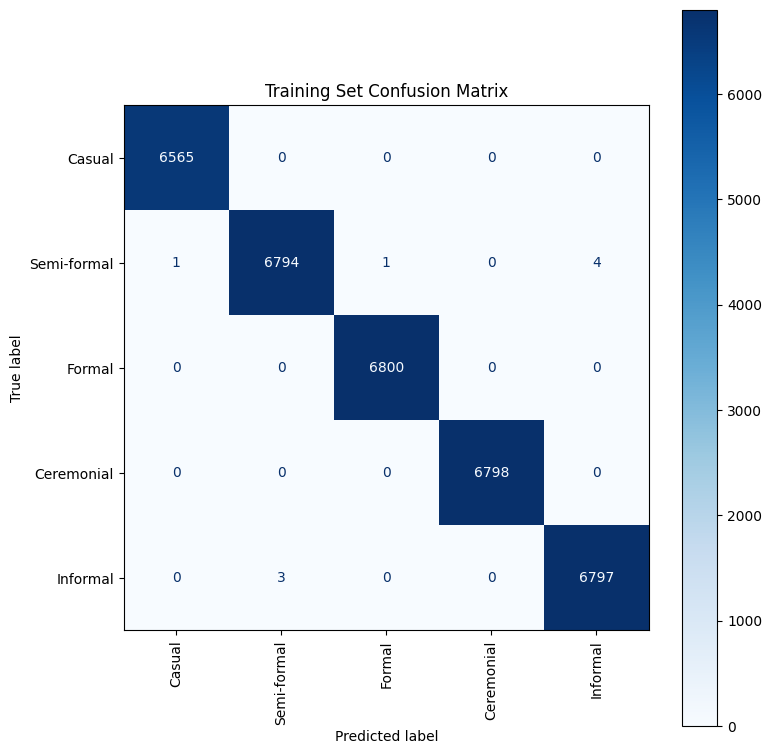

              precision    recall  f1-score   support

      Casual      1.000     1.000     1.000      6565
 Semi-formal      1.000     0.999     0.999      6800
      Formal      1.000     1.000     1.000      6800
  Ceremonial      1.000     1.000     1.000      6798
    Informal      0.999     1.000     0.999      6800

    accuracy                          1.000     33763
   macro avg      1.000     1.000     1.000     33763
weighted avg      1.000     1.000     1.000     33763


--- Validation Set Confusion Matrix ---


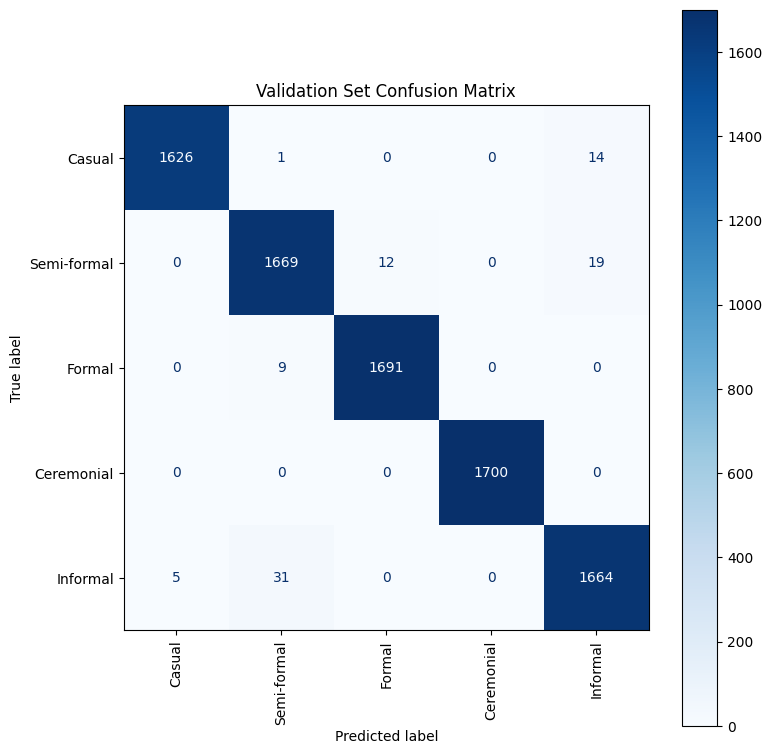

              precision    recall  f1-score   support

      Casual      0.997     0.991     0.994      1641
 Semi-formal      0.976     0.982     0.979      1700
      Formal      0.993     0.995     0.994      1700
  Ceremonial      1.000     1.000     1.000      1700
    Informal      0.981     0.979     0.980      1700

    accuracy                          0.989      8441
   macro avg      0.989     0.989     0.989      8441
weighted avg      0.989     0.989     0.989      8441


Confusion matrices displayed.


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names for display
class_names = [id2label_dict[i] for i in range(num_labels)]


# Translate this ['กันเอง', 'กึ่งทางการ', 'ทางการ', 'พิธีการ', 'ไม่เป็นทางการ']
# to be ['Casual', 'Semi-formal', 'Formal', 'Ceremonial', 'Informal'] manually
class_names = ['Casual', 'Semi-formal', 'Formal', 'Ceremonial', 'Informal']

# --- Plot Confusion Matrix for Training Set ---
print("\n--- Training Set Confusion Matrix ---")
cm_train = confusion_matrix(train_labels, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)

fig_train, ax_train = plt.subplots(figsize=(8, 8))
disp_train.plot(cmap=plt.cm.Blues, ax=ax_train, xticks_rotation='vertical')
ax_train.set_title("Training Set Confusion Matrix")
plt.tight_layout()
plt.show()

train_report = classification_report(
    train_labels,
    train_preds,
    target_names=class_names,
    digits=3
)
print(train_report)

# --- Plot Confusion Matrix for Validation Set ---
print("\n--- Validation Set Confusion Matrix ---")
cm_val = confusion_matrix(val_labels, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)

fig_val, ax_val = plt.subplots(figsize=(8, 8))
disp_val.plot(cmap=plt.cm.Blues, ax=ax_val, xticks_rotation='vertical')
ax_val.set_title("Validation Set Confusion Matrix")
plt.tight_layout()
plt.show()

val_report = classification_report(
    val_labels,
    val_preds,
    target_names=class_names,
    digits=3
)
print(val_report)

print("\nConfusion matrices displayed.")

### PhayathaiBert

In [8]:
tokenizer_name = "clicknext/phayathaibert"
model_name = "clicknext/phayathaibert"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label_dict,
    label2id=label2id_dict,
    problem_type='single_label_classification',
    ignore_mismatched_sizes=True
)

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Usage and output of tokenizer
sample_sentence = ds['train'][0]['output']
tokenizer(sample_sentence)

{'input_ids': [5, 9454, 260, 13742, 287, 2071, 54, 5461, 19241, 70, 11364, 70, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
def tokenize_and_encode(examples):
  return tokenizer(examples["output"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1 = f1_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    return {"f1_macro": f1, "accuracy": accuracy}

tokenized_train_ds = ds["train"].map(tokenize_and_encode, batched=True)
tokenized_test_ds = ds["test"].map(tokenize_and_encode, batched=True)

Map:   0%|          | 0/33763 [00:00<?, ? examples/s]

Map:   0%|          | 0/8441 [00:00<?, ? examples/s]

In [12]:
from transformers import TrainingArguments, Trainer

output_dir = "./results"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,            # Main parameters for finetuning
    per_device_train_batch_size=40, # Main parameters for finetuning
    per_device_eval_batch_size=40,  # Main parameters for finetuning
    learning_rate=2e-5,             # Main parameters for finetuning
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    fp16=True if "cuda" in str(model.device) else False, # Enable mixed precision training if GPU is available
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [13]:
print("\nStarting training...")
trainer.train()
print("\nTraining complete!")


Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.406500,0.141896,0.949770,0.949414
2,0.086300,0.082640,0.975691,0.975595
3,0.054300,0.065224,0.982970,0.982940
4,0.033900,0.056649,0.985882,0.985784
5,0.023400,0.068743,0.984120,0.984007
6,0.015900,0.054366,0.988337,0.988272
7,0.012900,0.056334,0.988422,0.988390
8,0.007500,0.070169,0.987379,0.987324
9,0.004800,0.060795,0.989377,0.989338
10,0.002500,0.061735,0.989628,0.989575



Training complete!


In [ ]:
# Get predictions for the training set
print("\nGenerating predictions for the training set...")
train_predictions = trainer.predict(tokenized_train_ds)
train_preds = np.argmax(train_predictions.predictions, axis=-1)
train_labels = train_predictions.label_ids

# Get predictions for the validation (test) set
print("Generating predictions for the validation set...")
val_predictions = trainer.predict(tokenized_test_ds)
val_preds = np.argmax(val_predictions.predictions, axis=-1)
val_labels = val_predictions.label_ids


Generating predictions for the training set...


Generating predictions for the validation set...


In [14]:
model_path = "Thangkarn-model"

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('Thangkarn-model/tokenizer_config.json',
 'Thangkarn-model/special_tokens_map.json',
 'Thangkarn-model/sentencepiece.bpe.model',
 'Thangkarn-model/added_tokens.json',
 'Thangkarn-model/tokenizer.json')

In [15]:
repo_name = "nnudee/Thai-Thangkarn-classifier"

create_repo(repo_id=repo_name, private=False)

upload_folder(
    folder_path=model_path,
    path_in_repo="",
    repo_id=repo_name
)

print(f"✅ โมเดลถูกอัปโหลดที่: https://huggingface.co/{repo_name}")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

✅ โมเดลถูกอัปโหลดที่: https://huggingface.co/nnudee/Thai-Thangkarn-classifier



--- Training Set Confusion Matrix ---


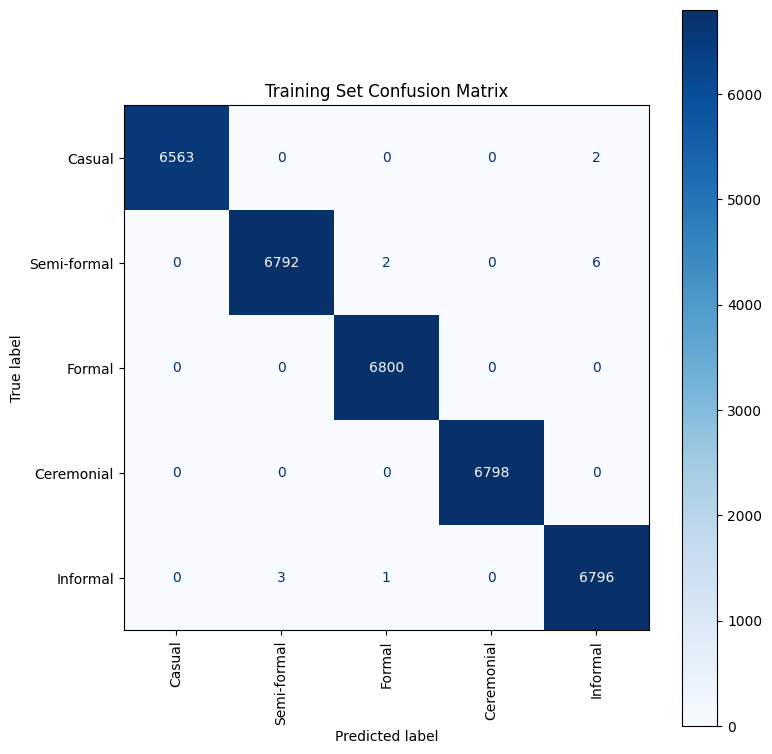

              precision    recall  f1-score   support

      Casual      1.000     1.000     1.000      6565
 Semi-formal      1.000     0.999     0.999      6800
      Formal      1.000     1.000     1.000      6800
  Ceremonial      1.000     1.000     1.000      6798
    Informal      0.999     0.999     0.999      6800

    accuracy                          1.000     33763
   macro avg      1.000     1.000     1.000     33763
weighted avg      1.000     1.000     1.000     33763


--- Validation Set Confusion Matrix ---


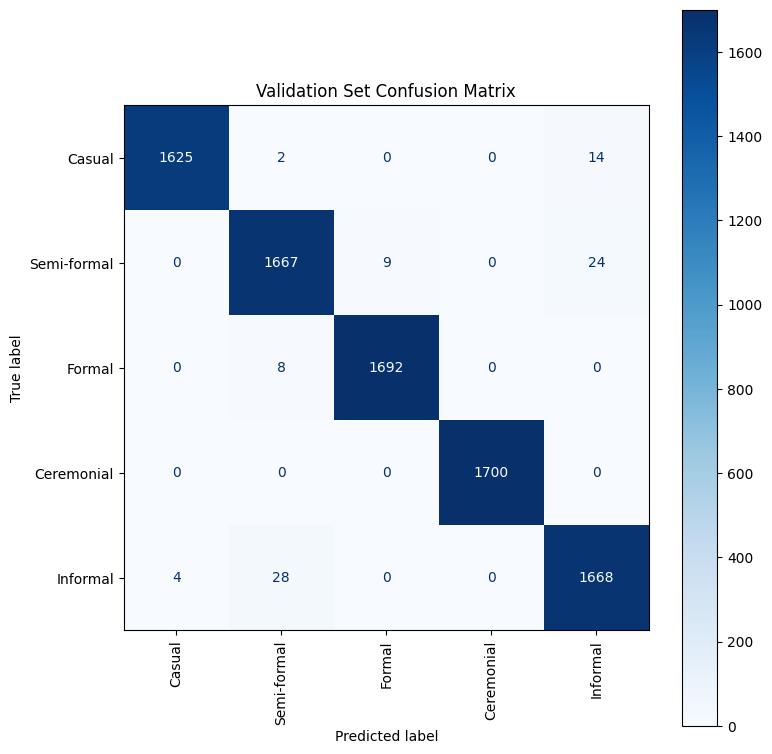

              precision    recall  f1-score   support

      Casual      0.998     0.990     0.994      1641
 Semi-formal      0.978     0.981     0.979      1700
      Formal      0.995     0.995     0.995      1700
  Ceremonial      1.000     1.000     1.000      1700
    Informal      0.978     0.981     0.979      1700

    accuracy                          0.989      8441
   macro avg      0.990     0.989     0.989      8441
weighted avg      0.989     0.989     0.989      8441


Confusion matrices displayed.


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names for display
class_names = [id2label_dict[i] for i in range(num_labels)]


# Translate this ['กันเอง', 'กึ่งทางการ', 'ทางการ', 'พิธีการ', 'ไม่เป็นทางการ']
# to be ['Casual', 'Semi-formal', 'Formal', 'Ceremonial', 'Informal'] manually
class_names = ['Casual', 'Semi-formal', 'Formal', 'Ceremonial', 'Informal']

# --- Plot Confusion Matrix for Training Set ---
print("\n--- Training Set Confusion Matrix ---")
cm_train = confusion_matrix(train_labels, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)

fig_train, ax_train = plt.subplots(figsize=(8, 8))
disp_train.plot(cmap=plt.cm.Blues, ax=ax_train, xticks_rotation='vertical')
ax_train.set_title("Training Set Confusion Matrix")
plt.tight_layout()
plt.show()

train_report = classification_report(
    train_labels,
    train_preds,
    target_names=class_names,
    digits=3
)
print(train_report)

# --- Plot Confusion Matrix for Validation Set ---
print("\n--- Validation Set Confusion Matrix ---")
cm_val = confusion_matrix(val_labels, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)

fig_val, ax_val = plt.subplots(figsize=(8, 8))
disp_val.plot(cmap=plt.cm.Blues, ax=ax_val, xticks_rotation='vertical')
ax_val.set_title("Validation Set Confusion Matrix")
plt.tight_layout()
plt.show()

val_report = classification_report(
    val_labels,
    val_preds,
    target_names=class_names,
    digits=3
)
print(val_report)

print("\nConfusion matrices displayed.")

### Error analysis

In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import numpy as np

In [10]:
ds_pd = ds['test'].to_pandas()
ds_pd.reset_index(inplace = True)
ds_pd

,index,label,category,output,reasoning,model
0,0,1,attendance issues,อาจารย์คะ ขอแจ้งว่าหนูมีเหตุฉุกเฉินที่บ้าน ต้อ...,ข้อความนี้ใช้ภาษาสุภาพแต่เป็นประโยคที่อ่านง่าย...,gpt-4.1-2025-04-14
1,1,1,submission notifications,อาจารย์คะ ผมมีปัญหากับไฟล์ที่ส่งไปครับ มันเกิด...,"This text is semi-formal, using polite and app...",typhoon-v2-70b-instruct
2,2,4,attendance issues,สวัสดีค่ะ อาจารย์ วันนี้ตัวเองอาจจะเข้าชั้นเรี...,"This text is informal but polite, using everyd...",typhoon-v2-70b-instruct
3,3,1,attendance issues,สวัสดีค่ะ อาจารย์ วันนี้ผู้จัดทำอาจจะมาไม่ทันเ...,"This text is semi-formal, using polite and app...",typhoon-v2-70b-instruct
4,4,3,attendance issues,ข้าพระพุทธเจ้าใคร่ขอกราบเรียนอาจารย์ด้วยความเค...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
...,...,...,...,...,...,...
8436,8436,1,attendance issues,เรียนอาจารย์ ฉันขอแจ้งลาการเข้าเรียนในวันพรุ...,"This text is semi-formal, using polite and app...",typhoon-v2-70b-instruct
8437,8437,4,document requests,ครูคะ หนูขอแบบฟอร์มหน่อยได้ไหมคะ ขอบคุณค่ะ,"This text is informal but polite, using everyd...",typhoon-v2-70b-instruct
8438,8438,3,document requests,ข้าพระพุทธเจ้าใคร่ขอกราบเรียนศาสตราจารย์ด้วยคว...,"This text is highly ceremonial and formal, usi...",typhoon-v2-70b-instruct
8439,8439,4,submission notifications,สวัสดีค่ะอาจารย์ ฉันขอแจ้งว่าจะมีการเลื่อนการส...,"This text is informal but polite, using everyd...",typhoon-v2-70b-instruct


In [12]:
MODEL_NAME = "nnudee/Thai-Thangkarn-classifier"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

texts = ds_pd["output"].tolist()
true_labels = ds_pd["label"].tolist()
pred_labels = []

In [13]:
for text in tqdm(texts):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        pred_labels.append(pred)

100%|██████████| 8441/8441 [20:46<00:00,  6.77it/s]


In [14]:
df_error = pd.DataFrame({
    "output": texts,
    "true_label": true_labels,
    "pred_label": pred_labels
})


In [15]:
if model.config.id2label:
    df_error["true_label_name"] = df_error["true_label"].map(model.config.id2label)
    df_error["pred_label_name"] = df_error["pred_label"].map(model.config.id2label)

df_error["is_correct"] = df_error["true_label"] == df_error["pred_label"]
df_wrong = df_error[df_error["is_correct"] == False].copy()

df_wrong
# แสดงผล
#print(df_wrong[["text", "true_label_name", "pred_label_name"]].head(10))

,output,true_label,pred_label,true_label_name,pred_label_name,is_correct
21,อาจารย์คะ หนูอยากขอคำแนะนำเพิ่มเติมเกี่ยวกับกา...,1,4,กึ่งทางการ,ไม่เป็นทางการ,False
78,อาจารย์คะ หนูอยากขอบคุณสำหรับความช่วยเหลือแล้ว...,1,4,กึ่งทางการ,ไม่เป็นทางการ,False
253,อาจารย์คะ หนูมีเรื่องด่วนเกิดขึ้นกระทันหัน ทำใ...,4,1,ไม่เป็นทางการ,กึ่งทางการ,False
287,อาจารย์ครับ วันนี้หนูไม่สบายมากเลย ขออนุญาตลาเ...,0,1,กันเอง,กึ่งทางการ,False
387,เรียนอาจารย์ ฉันขอความกรุณาอาจารย์ช่วยออกใบร...,4,1,ไม่เป็นทางการ,กึ่งทางการ,False
...,...,...,...,...,...,...
8226,อาจารย์คะ ขอบคุณมากๆ เลยค่ะ ที่ให้คำแนะนำและช่...,4,1,ไม่เป็นทางการ,กึ่งทางการ,False
8244,อาจารย์คะ หนูมีเรื่องอยากขอความช่วยเหลือค่ะ อย...,0,4,กันเอง,ไม่เป็นทางการ,False
8252,เรียนอาจารย์ วันนี้เราประสบปัญหาที่ไม่คาดคิด...,1,4,กึ่งทางการ,ไม่เป็นทางการ,False
8291,อาจารย์คะ หนูมีปัญหาในการทำโปรเจกต์ เลยทำให้ไม...,1,4,กึ่งทางการ,ไม่เป็นทางการ,False


In [16]:
df_wrong.drop(columns=['true_label','pred_label','is_correct'], inplace=True)

In [17]:
df_wrong.to_csv('Error_analyse.csv', index=False)

In [18]:
df_wrong

,output,true_label_name,pred_label_name
21,อาจารย์คะ หนูอยากขอคำแนะนำเพิ่มเติมเกี่ยวกับกา...,กึ่งทางการ,ไม่เป็นทางการ
78,อาจารย์คะ หนูอยากขอบคุณสำหรับความช่วยเหลือแล้ว...,กึ่งทางการ,ไม่เป็นทางการ
253,อาจารย์คะ หนูมีเรื่องด่วนเกิดขึ้นกระทันหัน ทำใ...,ไม่เป็นทางการ,กึ่งทางการ
287,อาจารย์ครับ วันนี้หนูไม่สบายมากเลย ขออนุญาตลาเ...,กันเอง,กึ่งทางการ
387,เรียนอาจารย์ ฉันขอความกรุณาอาจารย์ช่วยออกใบร...,ไม่เป็นทางการ,กึ่งทางการ
...,...,...,...
8226,อาจารย์คะ ขอบคุณมากๆ เลยค่ะ ที่ให้คำแนะนำและช่...,ไม่เป็นทางการ,กึ่งทางการ
8244,อาจารย์คะ หนูมีเรื่องอยากขอความช่วยเหลือค่ะ อย...,กันเอง,ไม่เป็นทางการ
8252,เรียนอาจารย์ วันนี้เราประสบปัญหาที่ไม่คาดคิด...,กึ่งทางการ,ไม่เป็นทางการ
8291,อาจารย์คะ หนูมีปัญหาในการทำโปรเจกต์ เลยทำให้ไม...,กึ่งทางการ,ไม่เป็นทางการ


In [20]:
grouped = df_wrong.groupby(["true_label_name", "pred_label_name"])

for (true_label, pred_label), group in grouped:
    print(f"\n{true_label} → {pred_label} ({len(group)} ตัวอย่าง)")
    display(group[["output", "true_label_name", "pred_label_name"]].reset_index(drop=True))



กันเอง → กึ่งทางการ (2 ตัวอย่าง)


,output,true_label_name,pred_label_name
0,อาจารย์ครับ วันนี้หนูไม่สบายมากเลย ขออนุญาตลาเ...,กันเอง,กึ่งทางการ
1,เรียนอาจารย์ หนูขอความช่วยเหลือเกี่ยวกับการท...,กันเอง,กึ่งทางการ



กันเอง → ไม่เป็นทางการ (9 ตัวอย่าง)


,output,true_label_name,pred_label_name
0,สวัสดีค่ะอาจารย์ เราขอบคุณมากๆ นะคะที่สอนเราอย...,กันเอง,ไม่เป็นทางการ
1,อาจารย์จ๋า หนูขอโทษนะคะ เมื่อวานส่งผิดไฟล์ไปเล...,กันเอง,ไม่เป็นทางการ
2,สวัสดีค่ะอาจารย์ ฉันอยากขอรบกวนให้อาจารย์ช่ว...,กันเอง,ไม่เป็นทางการ
3,อาจารย์จ๋า หนูอยากคุยเรื่องโปรเจกต์นิดนึง มีเว...,กันเอง,ไม่เป็นทางการ
4,อาจารย์ ลงชื่อให้หนูหน่อยนะคะ หนูขอใบรับรองสถา...,กันเอง,ไม่เป็นทางการ
5,เรียนอาจารย์ เราขอแจ้งล่วงหน้าว่าเราจะไม่สาม...,กันเอง,ไม่เป็นทางการ
6,อาจารย์คะ หนูไม่สบายเลยขอลาป่วยล่วงหน้าหน่อยนะ...,กันเอง,ไม่เป็นทางการ
7,อาจารย์คะ หนูขอใบ transcript หน่อยนะคะ จะเอาไป...,กันเอง,ไม่เป็นทางการ
8,อาจารย์คะ หนูมีเรื่องอยากขอความช่วยเหลือค่ะ อย...,กันเอง,ไม่เป็นทางการ



กึ่งทางการ → ทางการ (10 ตัวอย่าง)


,output,true_label_name,pred_label_name
0,อาจารย์ครับ ข้าพเจ้าขอแจ้งว่ามีปัญหาทางเทคนิคใ...,กึ่งทางการ,ทางการ
1,เรียนอาจารย์ที่เคารพ ดิฉันขอความกรุณาอาจารย์ช่...,กึ่งทางการ,ทางการ
2,เรียนอาจารย์ที่เคารพ ดิฉันขอขอบพระคุณสำหรับควา...,กึ่งทางการ,ทางการ
3,เรียนอาจารย์ที่เคารพ ดิฉันขอความกรุณาอาจารย์ช่...,กึ่งทางการ,ทางการ
4,เรียนอาจารย์ที่เคารพ ดิฉันขอขอบพระคุณสำหรับควา...,กึ่งทางการ,ทางการ
5,ดิฉันขอขอบพระคุณอาจารย์อย่างสูงสำหรับความกรุณา...,กึ่งทางการ,ทางการ
6,ดิฉันขอรบกวนอาจารย์ช่วยออกใบรับรองการเข้าเรียน...,กึ่งทางการ,ทางการ
7,อาจารย์ครับ ผมต้องการขออนุญาตออกจากห้องเรียนก...,กึ่งทางการ,ทางการ
8,เรียนอาจารย์ที่เคารพ ดิฉันขอแจ้งลาการเข้าเรียน...,กึ่งทางการ,ทางการ
9,เรียนอาจารย์ที่เคารพ ดิฉันขอความกรุณาอาจารย์ช่...,กึ่งทางการ,ทางการ



กึ่งทางการ → ไม่เป็นทางการ (16 ตัวอย่าง)


,output,true_label_name,pred_label_name
0,อาจารย์คะ หนูอยากขอคำแนะนำเพิ่มเติมเกี่ยวกับกา...,กึ่งทางการ,ไม่เป็นทางการ
1,อาจารย์คะ หนูอยากขอบคุณสำหรับความช่วยเหลือแล้ว...,กึ่งทางการ,ไม่เป็นทางการ
2,สวัสดีค่ะอาจารย์ หนูอยากขอคำแนะนำเรื่องการเตรี...,กึ่งทางการ,ไม่เป็นทางการ
3,เรียนอาจารย์ครับ ผมติดธุระด่วนในวันนี้ จึงไม...,กึ่งทางการ,ไม่เป็นทางการ
4,สวัสดีค่ะ อาจารย์ ฉันมีเรื่องด่วนต้องแจ้งล่วงห...,กึ่งทางการ,ไม่เป็นทางการ
5,อาจารย์คะ หนูขอแจ้งว่าส่งงานล่าช้านิดหน่อยนะคะ...,กึ่งทางการ,ไม่เป็นทางการ
6,เรียนอาจารย์ ฉันขอแจ้งว่าฉันไม่สามารถส่งงานต...,กึ่งทางการ,ไม่เป็นทางการ
7,อาจารย์คะ หนูขอขอบคุณอาจารย์มากๆ เลยค่ะ ที่ให้...,กึ่งทางการ,ไม่เป็นทางการ
8,สวัสดีครับอาจารย์ ผมต้องขอแจ้งลาป่วยในวันนี้ เ...,กึ่งทางการ,ไม่เป็นทางการ
9,อาจารย์คะ ผมอยากขอคำแนะนำเกี่ยวกับโปรเจกต์นี้ห...,กึ่งทางการ,ไม่เป็นทางการ



ทางการ → กึ่งทางการ (10 ตัวอย่าง)


,output,true_label_name,pred_label_name
0,อาจารย์ครับ ผมขอความกรุณาอาจารย์ช่วยจัดทำหนังส...,ทางการ,กึ่งทางการ
1,เรียนอาจารย์ที่เคารพ ดิฉันขอแจ้งลาการเข้าเรียน...,ทางการ,กึ่งทางการ
2,เรียนอาจารย์ที่เคารพ ดิฉันขอแจ้งว่าการอัปโหลดเ...,ทางการ,กึ่งทางการ
3,อาจารย์คะ หนูขอรบกวนถามเกี่ยวกับการเลือกหัวข้อ...,ทางการ,กึ่งทางการ
4,เรียนอาจารย์ที่เคารพ ดิฉันขอแจ้งลาการเข้าเรียน...,ทางการ,กึ่งทางการ
5,เรียนอาจารย์ที่เคารพ ผมขอแจ้งให้ทราบว่าผมไม่สา...,ทางการ,กึ่งทางการ
6,เรียนอาจารย์ที่เคารพ ดิฉันขอแจ้งว่าจะเข้าเรียน...,ทางการ,กึ่งทางการ
7,เรียนอาจารย์ที่เคารพ ดิฉันขอขอบพระคุณอาจารย์อย...,ทางการ,กึ่งทางการ
8,อาจารย์คะ หนูขอรบกวนเรื่องการวิเคราะห์ข้อมูลร่...,ทางการ,กึ่งทางการ
9,เรียนอาจารย์ที่เคารพ ดิฉันขอแจ้งเรื่องการขาดเร...,ทางการ,กึ่งทางการ



ไม่เป็นทางการ → กันเอง (3 ตัวอย่าง)


,output,true_label_name,pred_label_name
0,อาจารย์คะ หนูหาข้อมูลวิจัยตรงนี้ไม่เจอเลย รบกว...,ไม่เป็นทางการ,กันเอง
1,อาจารย์ครับ เรามาช้าไปนิดนึง ขอโทษด้วยนะครับ,ไม่เป็นทางการ,กันเอง
2,สวัสดีค่ะ อาจารย์ ผมมีเรื่องอยากขอรบกวนอาจารย์...,ไม่เป็นทางการ,กันเอง



ไม่เป็นทางการ → กึ่งทางการ (38 ตัวอย่าง)


,output,true_label_name,pred_label_name
0,อาจารย์คะ หนูมีเรื่องด่วนเกิดขึ้นกระทันหัน ทำใ...,ไม่เป็นทางการ,กึ่งทางการ
1,เรียนอาจารย์ ฉันขอความกรุณาอาจารย์ช่วยออกใบร...,ไม่เป็นทางการ,กึ่งทางการ
2,อาจารย์คะ วันนี้หนูมีเหตุฉุกเฉินที่บ้าน เลยอาจ...,ไม่เป็นทางการ,กึ่งทางการ
3,อาจารย์คะ หนูขอแจ้งว่ามีปัญหาในการส่งงานที่กำห...,ไม่เป็นทางการ,กึ่งทางการ
4,อาจารย์คะ หนูได้ส่งเอกสารเสนอโครงการไปแล้ว อยา...,ไม่เป็นทางการ,กึ่งทางการ
5,อาจารย์คะ ผมต้องการส่งงาน แต่มีปัญหาเกี่ยวกับก...,ไม่เป็นทางการ,กึ่งทางการ
6,อาจารย์คะ หนูยังไม่สามารถส่งงานได้ค่ะ เพราะมีป...,ไม่เป็นทางการ,กึ่งทางการ
7,เรียนอาจารย์ หนูรบกวนขอให้อาจารย์ช่วยตรวจสอบ...,ไม่เป็นทางการ,กึ่งทางการ
8,เรียนอาจารย์ ฉันขออนุญาตขอใบรับรองจากอาจารย์...,ไม่เป็นทางการ,กึ่งทางการ
9,สวัสดีครับ อาจารย์ ผมไม่สามารถเข้าเรียนได้ในวั...,ไม่เป็นทางการ,กึ่งทางการ


In [3]:
import pandas as pd

df_wrong = pd.read_csv('./Error_analyse.csv')  # ลองไม่ใส่ lines=True ก่อน

In [9]:
grouped = df_wrong.groupby(["true_label_name", "pred_label_name"])

for (true_label, pred_label), group in grouped:
    print(f"{true_label} → {pred_label} ({len(group)} ตัวอย่าง)")
    for i, row in group.iterrows():
        print(f"- {row['output']}")

กันเอง → กึ่งทางการ (2 ตัวอย่าง)
- อาจารย์ครับ วันนี้หนูไม่สบายมากเลย ขออนุญาตลาเรียนวันนี้ได้ไหมครับ?
- เรียนอาจารย์   หนูขอความช่วยเหลือเกี่ยวกับการทำวิจัยหน่อยค่ะ หนูมีปัญหาเรื่องหาข้อมูลและวิเคราะห์ข้อมูลอยู่ อยากรู้ว่าอาจารย์มีวิธีไหนแนะนำบ้างคะ
กันเอง → ไม่เป็นทางการ (9 ตัวอย่าง)
- สวัสดีค่ะอาจารย์ เราขอบคุณมากๆ นะคะที่สอนเราอย่างดีตลอดเวลา ขอให้อาจารย์สุขภาพแข็งแรงนะคะ
- อาจารย์จ๋า หนูขอโทษนะคะ เมื่อวานส่งผิดไฟล์ไปเลยพลาดเส้นตาย ขอให้อาจารย์ใจดีช่วยรับไฟล์ใหม่ทีนะคะ
- สวัสดีค่ะอาจารย์   ฉันอยากขอรบกวนให้อาจารย์ช่วยลงชื่อในเอกสารนี้ให้หน่อยได้ไหมคะ ถ้าอาจารย์ว่างก็ขอบคุณมากๆ เลยนะคะ
- อาจารย์จ๋า หนูอยากคุยเรื่องโปรเจกต์นิดนึง มีเวลาไหมคะ?
- อาจารย์ ลงชื่อให้หนูหน่อยนะคะ หนูขอใบรับรองสถานะนักเรียนค่ะ
- เรียนอาจารย์   เราขอแจ้งล่วงหน้าว่าเราจะไม่สามารถเข้าเรียนได้ในวันพรุ่งนี้นะคะ ขอโทษด้วยค่ะ
- อาจารย์คะ หนูไม่สบายเลยขอลาป่วยล่วงหน้าหน่อยนะคะ ขอบคุณค่ะ
- อาจารย์คะ หนูขอใบ transcript หน่อยนะคะ จะเอาไปสมัครฝึกงานค่ะ
- อาจารย์คะ หนูมีเรื่องอยากขอความช่วยเหลือค่ะ อยากรู้ว่ามีใบรับรองส